
# Comprehensive evaluation framework for recommendation systems
    
    Metrics:
    - Accuracy: RMSE, MAE, MAPE
    - Ranking: Precision@K, Recall@K, NDCG@K, MAP@K
    - Coverage: Catalog coverage, User coverage
    - Diversity: Intra-list diversity, Genre diversity
    - Novelty: Average popularity of recommendations
    - Serendipity: Unexpected but relevant recommendations
 

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

import sys
sys.path.append('Notebook\EDA & Data_Preprocessing.ipynb')

In [2]:
%run "EDA & Data_Preprocessing.ipynb"


Dataset shapes:
Anime: (12294, 7)
Ratings: (7813737, 3)

--- Anime Dataset ---

--- Rating Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

---- Anime Statistics ----

--- Rating Statistics ----

--- Missing Values ---
(12294, 53)
(7788750, 12)
(7788750, 1

In [3]:
anime_df = pd.read_csv(r'D:\#Great Learning\MY\Project\Anime_Recommendation_System\anime_dataset\anime.csv')
rating_df = pd.read_csv(r'D:\#Great Learning\MY\Project\Anime_Recommendation_System\anime_dataset\rating.csv')

In [4]:
class RecommenderEvaluator:
    def __init__(self, train_data, test_data, anime_df):
        self.train_data = train_data
        self.test_data = test_data
        self.anime_df = anime_df

    # ============ ACCURACY METRICS ============
    
    def calculate_rmse(self, predictions, actuals):
        """Root Mean Square Error"""
        return np.sqrt(mean_squared_error(actuals, predictions))
    
    def calculate_mae(self, predictions, actuals):
        """Mean Absolute Error"""
        return mean_absolute_error(actuals, predictions)
    
    def calculate_mape(self, predictions, actuals):
        """Mean Absolute Percentage Error"""
        return np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    # ============ RANKING METRICS ============
    
    def precision_at_k(self, recommended_items, relevant_items, k=10):
        """
        Precision@K: Fraction of recommended items that are relevant
        
        P@K = |recommended ∩ relevant| / K
        """
        recommended_k = set(recommended_items[:k])
        relevant = set(relevant_items)
        return len(recommended_k.intersection(relevant)) / k if k > 0 else 0
    
    def recall_at_k(self, recommended_items, relevant_items, k=10):
        """
        Recall@K: Fraction of relevant items that are recommended
        
        R@K = |recommended ∩ relevant| / |relevant|
        """
        recommended_k = set(recommended_items[:k])
        relevant = set(relevant_items)
        return len(recommended_k.intersection(relevant)) / len(relevant) if len(relevant) > 0 else 0
    
    def f1_at_k(self, recommended_items, relevant_items, k=10):
        """F1 Score at K"""
        precision = self.precision_at_k(recommended_items, relevant_items, k)
        recall = self.recall_at_k(recommended_items, relevant_items, k)
        
        if precision + recall == 0:
            return 0
        return 2 * (precision * recall) / (precision + recall)
    
    def ndcg_at_k(self, recommended_items, relevant_items, k=10):
        """
        Normalized Discounted Cumulative Gain at K
        
        DCG = Σ(rel_i / log2(i+1))
        NDCG = DCG / IDCG (ideal DCG)
        """
        def dcg(relevance_scores):
            return sum(
                (2**rel - 1) / np.log2(idx + 2)
                for idx, rel in enumerate(relevance_scores)
            )
        
        # Create relevance scores (1 if relevant, 0 otherwise)
        recommended_k = recommended_items[:k]
        relevance = [1 if item in relevant_items else 0 for item in recommended_k]
        
        if sum(relevance) == 0:
            return 0
        
        # Calculate DCG
        dcg_score = dcg(relevance)
        
        # Calculate ideal DCG (if all relevant items were at top)
        ideal_relevance = sorted(relevance, reverse=True)
        idcg_score = dcg(ideal_relevance)
        
        return dcg_score / idcg_score if idcg_score > 0 else 0
    
    def map_at_k(self, recommended_items, relevant_items, k=10):
        """
        Mean Average Precision at K
        
        MAP@K = (1/|relevant|) * Σ P(i) * rel(i)
        where P(i) is precision at position i
        """
        recommended_k = recommended_items[:k]
        relevant = set(relevant_items)
        
        if len(relevant) == 0:
            return 0
        
        score = 0
        num_relevant = 0
        
        for i, item in enumerate(recommended_k):
            if item in relevant:
                num_relevant += 1
                precision_at_i = num_relevant / (i + 1)
                score += precision_at_i
        
        return score / len(relevant)
    
    # ============ COVERAGE METRICS ============
    
    def catalog_coverage(self, all_recommendations):
        """
        Catalog Coverage: Percentage of items that appear in recommendations
        
        Coverage = |recommended_items| / |all_items|
        """
        unique_recommended = set()
        for recs in all_recommendations:
            unique_recommended.update(recs)
        
        total_items = self.anime_df['anime_id'].nunique()
        return len(unique_recommended) / total_items
    
    def user_coverage(self, recommendations_dict):
        """
        User Coverage: Percentage of users who received recommendations
        """
        total_users = self.test_data['user_id'].nunique()
        users_with_recs = len(recommendations_dict)
        return users_with_recs / total_users
    
    def gini_coefficient(self, all_recommendations):
        """
        Gini Coefficient: Measures inequality in item exposure
        
        0 = perfect equality (all items recommended equally)
        1 = perfect inequality (few items dominate recommendations)
        """
        # Count frequency of each item
        item_counts = defaultdict(int)
        for recs in all_recommendations:
            for item in recs:
                item_counts[item] += 1
        
        # Calculate Gini
        frequencies = sorted(item_counts.values())
        n = len(frequencies)
        
        if n == 0:
            return 0
        
        cumsum = np.cumsum(frequencies)
        return (2 * sum((i+1) * freq for i, freq in enumerate(frequencies))) / (n * cumsum[-1]) - (n+1)/n
    
    # ============ DIVERSITY METRICS ============
    
    def intra_list_diversity(self, recommended_items):
        """
        Intra-List Diversity: Average pairwise dissimilarity within a recommendation list
        
        Higher = more diverse recommendations
        """
        if len(recommended_items) < 2:
            return 0
        
        # Get genres for recommended anime
        anime_genres = self.anime_df[
            self.anime_df['anime_id'].isin(recommended_items)
        ][['anime_id', 'genre']].set_index('anime_id')
        
        # Calculate pairwise genre dissimilarity
        dissimilarities = []
        for i, item1 in enumerate(recommended_items):
            for item2 in recommended_items[i+1:]:
                if item1 in anime_genres.index and item2 in anime_genres.index:
                    genres1 = set(anime_genres.loc[item1, 'genre'].split(', '))
                    genres2 = set(anime_genres.loc[item2, 'genre'].split(', '))
                    
                    # Jaccard dissimilarity
                    union = len(genres1.union(genres2))
                    intersection = len(genres1.intersection(genres2))
                    dissimilarity = 1 - (intersection / union if union > 0 else 0)
                    dissimilarities.append(dissimilarity)
        
        return np.mean(dissimilarities) if dissimilarities else 0
    
    def genre_diversity(self, recommended_items):
        """
        Genre Diversity: Number of unique genres in recommendations
        """
        anime_genres = self.anime_df[
            self.anime_df['anime_id'].isin(recommended_items)
        ]['genre']
        
        unique_genres = set()
        for genres_str in anime_genres:
            if pd.notna(genres_str):
                unique_genres.update(genres_str.split(', '))
        
        return len(unique_genres)
    
    # ============ NOVELTY & SERENDIPITY ============
    
    def novelty_score(self, recommended_items):
        """
        Novelty: Inverse of average popularity of recommended items
        
        Higher = recommending less popular (more novel) items
        """
        # Get popularity (rating count) for recommended items
        anime_popularity = self.train_data.groupby('anime_id').size()
        
        popularities = []
        for item in recommended_items:
            if item in anime_popularity.index:
                popularities.append(anime_popularity[item])
        
        if not popularities:
            return 0
        
        avg_popularity = np.mean(popularities)
        max_popularity = anime_popularity.max()
        
        # Normalize: higher novelty = lower popularity
        return 1 - (avg_popularity / max_popularity)
    
    def serendipity_score(self, recommended_items, expected_items):
        """
        Serendipity: Unexpected but relevant recommendations
        
        Serendipity = |recommended ∩ unexpected| / |recommended|
        where unexpected = relevant but not obvious
        """
        recommended = set(recommended_items)
        expected = set(expected_items)
        
        # Unexpected items = recommended but not expected
        unexpected = recommended - expected
        
        return len(unexpected) / len(recommended) if len(recommended) > 0 else 0
    
    # ============ COMPLETE EVALUATION ============
    
    def evaluate_model(self, recommendation_func, k=10, n_users=100):
        """
        Complete evaluation of a recommendation model
        
        Args:
            recommendation_func: Function that takes user_id and returns list of anime_ids
            k: Number of recommendations to evaluate
            n_users: Number of users to sample for evaluation
        
        Returns:
            Dictionary with all evaluation metrics
        """
        # Sample users from test set
        test_users = self.test_data['user_id'].unique()
        sample_users = np.random.choice(test_users, min(n_users, len(test_users)), replace=False)
        
        # Store metrics
        metrics = {
            'precision': [],
            'recall': [],
            'f1': [],
            'ndcg': [],
            'map': [],
            'diversity': [],
            'genre_diversity': [],
            'novelty': []
        }
        
        all_recommendations = []
        
        for user_id in sample_users:
            # Get recommendations
            try:
                recommended = recommendation_func(user_id, k)
                if isinstance(recommended, pd.DataFrame):
                    recommended_items = recommended['anime_id'].tolist()
                else:
                    recommended_items = recommended
            except:
                continue
            
            # Get ground truth (highly rated items in test set)
            user_test = self.test_data[self.test_data['user_id'] == user_id]
            relevant_items = user_test[user_test['rating'] >= 8]['anime_id'].tolist()
            
            if len(relevant_items) == 0:
                continue
            
            # Calculate metrics
            metrics['precision'].append(
                self.precision_at_k(recommended_items, relevant_items, k)
            )
            metrics['recall'].append(
                self.recall_at_k(recommended_items, relevant_items, k)
            )
            metrics['f1'].append(
                self.f1_at_k(recommended_items, relevant_items, k)
            )
            metrics['ndcg'].append(
                self.ndcg_at_k(recommended_items, relevant_items, k)
            )
            metrics['map'].append(
                self.map_at_k(recommended_items, relevant_items, k)
            )
            metrics['diversity'].append(
                self.intra_list_diversity(recommended_items)
            )
            metrics['genre_diversity'].append(
                self.genre_diversity(recommended_items)
            )
            metrics['novelty'].append(
                self.novelty_score(recommended_items)
            )
            
            all_recommendations.append(recommended_items)
        
        # Aggregate results
        results = {
            'Precision@K': np.mean(metrics['precision']),
            'Recall@K': np.mean(metrics['recall']),
            'F1@K': np.mean(metrics['f1']),
            'NDCG@K': np.mean(metrics['ndcg']),
            'MAP@K': np.mean(metrics['map']),
            'Catalog Coverage': self.catalog_coverage(all_recommendations),
            'Gini Coefficient': self.gini_coefficient(all_recommendations),
            'Avg Diversity': np.mean(metrics['diversity']),
            'Avg Genre Diversity': np.mean(metrics['genre_diversity']),
            'Avg Novelty': np.mean(metrics['novelty'])
        }
        
        return results




In [5]:
%run "EDA & Data_Preprocessing.ipynb"

anime_clean = preprocessor.preprocess_anime_data(anime_df)
rating_clean = preprocessor.preprocess_ratings(rating_df)
train_data, test_data = preprocessor.create_train_test_split(rating_clean)



Dataset shapes:
Anime: (12294, 7)
Ratings: (7813737, 3)

--- Anime Dataset ---

--- Rating Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

---- Anime Statistics ----

--- Rating Statistics ----

--- Missing Values ---
(12294, 53)
(7788750, 12)
(7788750, 1

Dataset shapes:
Anime: (12294, 7)
Ratings: (7813737, 3)

--- Anime Dataset ---

--- Rating Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

---- Anime Statistics ----

--- Rating Statistics ----

--- Missing Values ---

Cleaned ratings: 6337241 entries
Rat

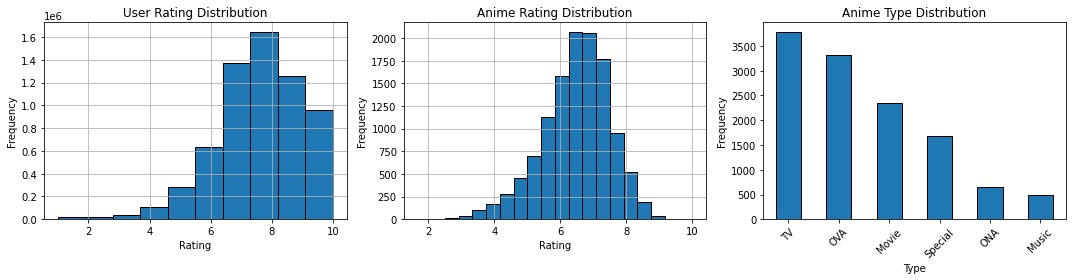

Top 10 rated anime:

USER-BASED COLLABORATIVE FILTERING

 User-Item Matrix Shape: {user_item_matrix.shape}
Matrix size would be: 69600 x 69600 users
Using on-demand similarity calculation (memory efficient)

--- User-Based Recommendations for User 1 ---
   anime_id  predicted_rating                       name  \
0     10793         10.000000               Guilty Crown   
1     18679         10.000000               Kill la Kill   
2     21881         10.000000        Sword Art Online II   
3     23755         10.000000          Nanatsu no Taizai   
4     24703          9.500766       High School DxD BorN   
5      9253          9.000000                Steins;Gate   
6     21603          9.000000          Mekakucity Actors   
7      6702          9.000000                 Fairy Tail   
8      9513          7.000000                  Beelzebub   
9      7088          5.000000  Ichiban Ushiro no Daimaou   

                                               genre type  rating  
0                

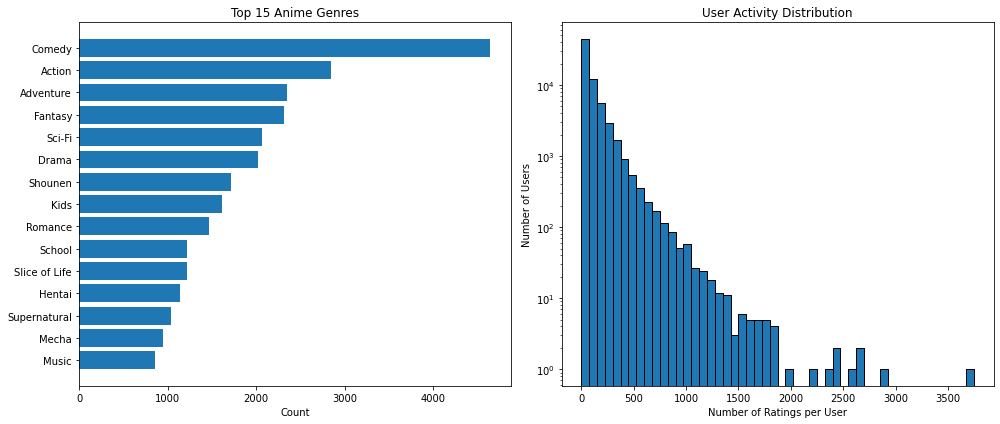


SAVING RESULTS
Recommendations saved to 'anime_recommendations.csv'

RECOMMENDATION SYSTEM COMPLETE!

You can now use the following functions:
- get_user_based_recommendations(user_id, n_recommendations)
- get_item_based_recommendations(user_id, n_recommendations)
- get_content_based_recommendations(anime_id, n_recommendations)
- get_hybrid_recommendations(user_id, n_recommendations)


In [6]:
%run "D:\#Great Learning\MY\Project\Anime_Recommendation_System\Anime_Recommendation_System.ipynb"

In [7]:
# Usage Example
evaluator = RecommenderEvaluator(train_data, test_data, anime_df)



In [ ]:
# # Evaluate a recommendation function
def my_recommender(user_id, k):
    return get_hybrid_recommendations(user_id, n_recommendations=k)

results = evaluator.evaluate_model(my_recommender, k=10, n_users=100)
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")